In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
users = pd.read_csv('../data/user_loss.csv', encoding='gbk')
info = pd.read_csv('../data/info_new.csv')
print('客户信息表的形状：', users.shape)
# print(users)
print('订单详情表的形状：', info.shape)
# print(info)

客户信息表的形状： (2431, 36)
订单详情表的形状： (6611, 21)


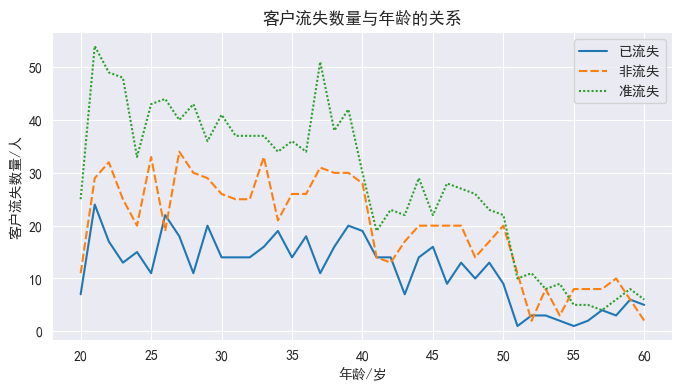

In [2]:
# 将时间转为时间格式
users['CREATED'] = pd.to_datetime(users['CREATED'])
info['use_start_time'] = pd.to_datetime(info['use_start_time'])
info['lock_time'] = pd.to_datetime(info['lock_time'])

# 客户流失与年龄的关系
a = users.loc[users['TYPE'] == '已流失', ['AGE', 'TYPE']]['AGE']. value_counts().sort_index()
b = users.loc[users['TYPE'] == '非流失', ['AGE', 'TYPE']]['AGE']. value_counts().sort_index()
c = users.loc[users['TYPE'] == '准流失', ['AGE', 'TYPE']]['AGE']. value_counts().sort_index()

# 绘制折线图
df = pd.DataFrame({'已流失': a.values,
                       '非流失': b.values,
                       '准流失': c.values},
                       index=range(20, 61, 1))
plt.rcParams['font.sans-serif']='SimHei'    #设置中文显示
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(8, 4))  # 确定画布大小 
sns.lineplot(data=df)
plt.xlabel('年龄/岁')  # 添加x轴标签
plt.ylabel('客户流失数量/人')  # 添加 y轴标签
plt.title('客户流失数量与年龄的关系')  # 添加图表标题
plt.savefig('../tmp/客户流失数量与年龄的关系.jpg', dpi=1080, bbox_inches='tight')
plt.show()

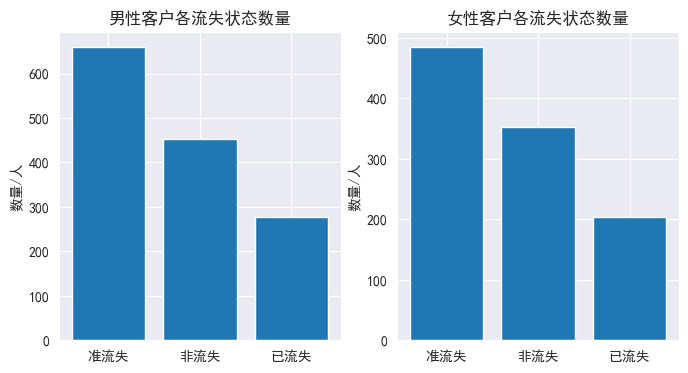

In [3]:
# 统计男性客户各流失状态数量
count1 = users[users['SEX']=='男']['TYPE'].value_counts()

# 统计女性客户各流失状态数量
count2 = users[users['SEX']=='女']['TYPE'].value_counts()

fig = plt.figure(figsize=[8, 4])  # 确定画布大小 
plt.subplot(1,2,1)  # 创建一个1行2列的图，并开始绘制第一幅子图
plt.bar(count1.index, count1)
plt.title('男性客户各流失状态数量')  # 添加第一幅子图的图表标题
plt.ylabel('数量/人')  # 添加第一幅子图的 y轴标签

plt.subplot(1,2,2)   # 绘制第二幅子图
plt.bar(count2.index,count2)
plt.title('女性客户各流失状态数量')  # 添加第二幅子图的图表标题
plt.ylabel('数量/人')  # 添加第二幅子图的 y轴标签
plt.savefig('../tmp/客户流失与性别的关系.jpg', dpi=1080, bbox_inches='tight')
plt.show()

In [4]:
print('订单详情表重复值数量：',
     info.duplicated(subset=['name', 'use_start_time']).sum())

订单详情表重复值数量： 0


In [5]:
# 选取dining_table_id和use_start_time都重复的的索引值
ind = info[info.duplicated(['dining_table_id', 
                            'use_start_time'])].index
print('同一时间同一张桌子被不同人使用的订单：\n',
      info[(info['dining_table_id'] == info.iloc[ind[1], :] 
            ['dining_table_id']) &
      (info['use_start_time'] == info.iloc[ind[1], :]
       ['use_start_time'])]
      [['info_id', 'dining_table_id','use_start_time']])

同一时间同一张桌子被不同人使用的订单：
       info_id  dining_table_id      use_start_time
2052     3392             1484 2023-03-26 21:55:00
2140     3480             1484 2023-03-26 21:55:00


In [6]:
info.drop(index=ind, inplace=True)
info = info.reset_index(drop=True)
print('异常值个数：', len(ind))
print('去除异常值后订单详情表形状：', info.shape)

异常值个数： 17
去除异常值后订单详情表形状： (6594, 21)


In [7]:
print('客户信息表缺失值数量：', info.isnull().sum().sum())
print('订单详情表缺失值数量：', users.isnull().sum().sum())

客户信息表缺失值数量： 46158
订单详情表缺失值数量： 50842


In [8]:
# 获取最后一次用餐时间
for i in range(len(users)):
        info1 = info.iloc[info[info['name'] == 
    users.iloc[i, 2]].index.tolist(), :]
        if sum(info['name'] == users.iloc[i, 2]) != 0:
              users.iloc[i, 14] = max(info1['use_start_time'])
# 获取订单状态为1的订单
info = info.loc[info['order_status'] == 1, 
['emp_id', 'number_consumers', 'expenditure']]
info = info.rename(columns={'emp_id': 'USER_ID'})  # 修改列名
user = users[['USER_ID', 'LAST_VISITS', 'TYPE']]

# 合并两个表
info_user = pd.merge(user, info, left_on='USER_ID', 
                     right_on= 'USER_ID', how='left')
print('合并表缺失值个数：\n', info_user.isnull().sum())
info_user.dropna(inplace=True)  #处理缺失值

info_user.to_csv('../tmp/info_user.csv', index=False, 
                 encoding= 'utf-8')

合并表缺失值个数：
 USER_ID               0
LAST_VISITS         155
TYPE                  0
number_consumers      7
expenditure           7
dtype: int64


In [22]:
print('处理缺失值后数据形状：\n', info_user.shape)

处理缺失值后数据形状：
 (6443, 5)


In [9]:
# 提取数据
info_user = pd.read_csv('../tmp/info_user.csv', encoding= 'utf-8')
# 统计每个人的用餐次数
info_user1 = info_user['USER_ID'].value_counts()  
info_user1 = info_user1.reset_index()
info_user1.columns = ['USER_ID', 'frequence']  # 修改列名

# 求出每个客户的总消费金额
# 分组求和
info_user2 = info_user[['number_consumers','expenditure'
                       ]].groupby(info_user['USER_ID']).sum()
info_user2 = info_user2.reset_index()
info_user2.columns = ['USER_ID', 'numbers', 'amount']
# 合并客户的用餐次数和消费总金额
data_new = pd.merge(info_user1, info_user2,left_on='USER_ID',
                    right_on='USER_ID', how= 'left')

# 提取数据
info_user = info_user.iloc[:, :4]
info_user = info_user.groupby(['USER_ID']).last()
info_user = info_user.reset_index()
# 合并数据
info_user_new = pd.merge(data_new, info_user,left_on='USER_ID', 
                         right_on='USER_ID', how='left')
print(info_user_new.head())

   USER_ID  frequence  numbers   amount          LAST_VISITS TYPE  \
0     2361         41    237.0  34784.0  2023-07-30 13:29:00  非流失   
1     3478         37    231.0  33570.0  2023-07-27 11:14:00  非流失   
2     3430         34    224.0  31903.0  2023-07-26 13:38:00  非流失   
3     2797         33    198.0  30849.0  2023-07-23 13:28:00  非流失   
4     3768         33    207.0  32699.0  2023-07-28 12:24:00  非流失   

   number_consumers  
0               7.0  
1               5.0  
2               5.0  
3               2.0  
4              10.0  


In [10]:
# 求人均销售额，并保留2位小数
info_user_new['average'] = info_user_new['amount'] / info_user_new['numbers']
info_user_new['average'] = info_user_new['average'].apply(lambda x: '%.2f' % x)

# 计算每个客户最近一次点餐的时间距离观测窗口结束时间的天数
# 修改时间列，改为日期
info_user_new['LAST_VISITS'] = pd.to_datetime(
    info_user_new['LAST_VISITS'])
datefinally = pd.to_datetime('2023-7-31')  # 观测窗口结束时间
time = datefinally - info_user_new['LAST_VISITS']
# 计算时间差
info_user_new['recently'] = time.apply(lambda x: x.days)
# 特征选取
info_user_new = info_user_new.loc[:, ['USER_ID', 'frequence',
                                      'amount', 'average', 
                                      'recently', 'TYPE']]
info_user_new.to_csv('../tmp/info_user_clear.csv', index=False, 
                     encoding='gbk')
print(info_user_new.head())

   USER_ID  frequence   amount average  recently TYPE
0     2361         41  34784.0  146.77         0  非流失
1     3478         37  33570.0  145.32         3  非流失
2     3430         34  31903.0  142.42         4  非流失
3     2797         33  30849.0  155.80         7  非流失
4     3768         33  32699.0  157.97         2  非流失
